In [1]:
import numpy as np
import scipy.integrate
import scipy.interpolate
%matplotlib inline
import matplotlib as mpl, matplotlib.pyplot as plt

from __future__ import print_function, division

mpl.rc('font', size=18)
mpl.rc('figure', figsize=(12,6))

In [2]:
# Constants used at some point (all converted to cgs units)
h = 0.671
solmass = 1.990e30 # kg
solmass *= 1000    # --> g
mu = 0.6 
mp = 1.673e-27 # kg
mp *= 1000     # --> g
G  = 6.674e-11 # m^3/(kg s^2)
G *= 1000      # --> cm^3/(g s^2) 
kB = 1.381e-23 # J/K
kB *= 1e7      # --> erg/K

cm_to_pc = (3e10 * 86400 * 365 * 3.26)
cm_to_kpc = cm_to_pc * 1000

rhocrit = 3 * (100 * h * 1e5 / (cm_to_pc * 1e6))**2 / (8 * np.pi * G)

#rhocrit = 1.879e-26 * h**2 # kg/m^3
#rhocrit /= 1000            # --> g/cm^3

# Temperature-density relation

In [19]:
log_nh  = np.linspace(-8.0, 0.0, 41)
log_T = np.array([2.91, 3.02, 3.13, 3.24, 3.36, 3.47, 3.59, 3.70, 3.81, 3.93, 4.04, 4.15, 4.25, 4.35,
                         4.44, 4.51, 4.54, 4.54, 4.51, 4.49, 4.43, 4.38, 4.32, 4.28, 4.24, 4.20, 4.17, 4.14,
                         4.12, 4.10, 4.08, 4.06, 4.04, 4.03, 4.01, 4.00, 3.99, 3.97, 3.96, 3.95, 3.94])

log_nh, log_T = np.loadtxt('data/T-nH.dat', unpack=True)

# For log n_H < -4.8, the rho-T relation can be approximated as a power law
# with parameters as follows
log_nh_approx_max = -5
T0 = 1e4
gamma0 = 0.54
rho0 = 1e-6 * mp
log_nh_approx = log_nh[log_nh < log_nh_approx_max]

def T_powerlaw_approx(lognh):
    rho = 10**lognh * mp
    return T0 * (rho/rho0)**gamma0

# Derivative of the power law function
def dT_drho_approx(lognh):
    rho = 10**lognh * mp
    return T0 * gamma0 * rho0**(-gamma0) * rho**(gamma0 - 1)

# Otherwise, T and dT/drho are interpolated from the data
#T_numerical = scipy.interpolate.UnivariateSpline(10**log_nh * mp, 10**log_T, s=0, k=1)
#dT_drho_numerical = T_numerical.derivative()

log_T_numerical = scipy.interpolate.UnivariateSpline(log_nh, log_T, s=0.001, k=3)
dlogT_dlognh_numerical = log_T_numerical.derivative()

def rho(lognh):
    return 10**lognh * mp

def T(lognh):
    return 10**log_T_numerical(lognh)

def dT_drho(lognh):
    return (T(lognh) / rho(lognh)) * dlogT_dlognh_numerical(lognh)

# check accuracy of interpolation
#plt.figure()
#ax = plt.gca()
#ax.set_ylabel(r'$T (K)$')
#ax.set_xlabel(r'$\log_{10}(n_H/\mathrm{cm}^{-3}$)')
#plt.plot(log_nh, T_numerical(10**log_nh * mp))
#plt.plot(log_nh, T(log_nh))

#plt.figure()
#ax = plt.gca()
#ax.set_ylabel(r'$\mathrm{d}T/\mathrm{d}\rho$')
#ax.set_xlabel(r'$\log_{10}(n_H/\mathrm{cm}^{-3}$)')
#plt.plot(log_nh, (dT_drho_numerical(10**log_nh * mp)))
#plt.plot(log_nh, dT_drho(log_nh));

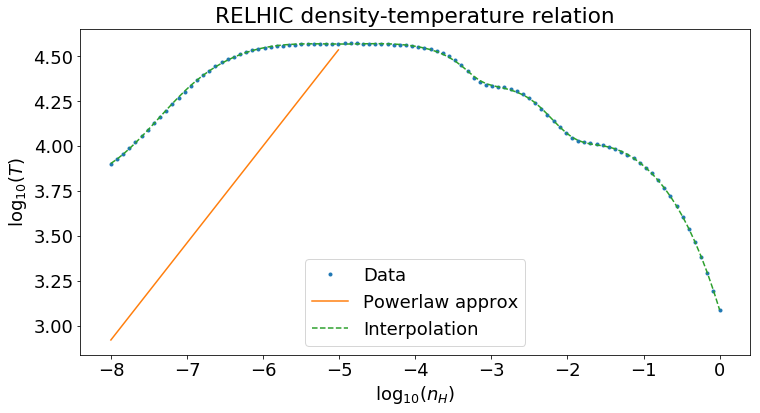

In [20]:
plt.figure()
ax = plt.gca()
ax.set_title('RELHIC density-temperature relation')
ax.set_xlabel(r'$\log_{10}(n_H)$')
ax.set_ylabel(r'$\log_{10}(T)$')
plt.plot(log_nh, log_T, '.', label='Data')
plt.plot(log_nh_approx, np.log10(T_powerlaw_approx(log_nh_approx)), label='Powerlaw approx')
plt.plot(log_nh, np.log10(T(log_nh)), '--', label='Interpolation')
plt.legend();

# $F(\rho)$

$$F(\rho)=\int_\bar{\rho}^\rho\left.\left(\frac{T}{\rho}+\frac{\mathrm{d}T}{\mathrm{d}\rho}\right)\right|_{\rho'}\,\mathrm{d}\rho'$$

In [21]:
# When the power law approximation can be used, F(rho) above can be solved analytically.

# Only consider densities above the mean background density
log_mean_nh = -6.7
log_nh_valid = log_nh[log_nh > log_mean_nh]
log_nh_analytic = np.intersect1d(log_nh_approx, log_nh_valid)

def F_analytic_approx(lognh):
    rhob = 10**log_mean_nh * mp
    return (T0 / rho0**gamma0) * ((gamma0 + 1) / gamma0) * (rho(lognh)**gamma0 - rhob**gamma0)

# Or we can do a numerical solution, which is valid for all densities
def F_integrand_numerical(lognh):
    log_int =  T(lognh) / rho(lognh) + dT_drho(lognh)
    # The integral is computed in log(nH) space
    # so a conversion back into rho space is required 
    return log_int * 10**lognh * mp * 2.303 # ln(10)

def F_numerical(lognh):
    return scipy.integrate.quad(F_integrand_numerical, log_mean_nh, lognh)[0]

/home/calvin/.local/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


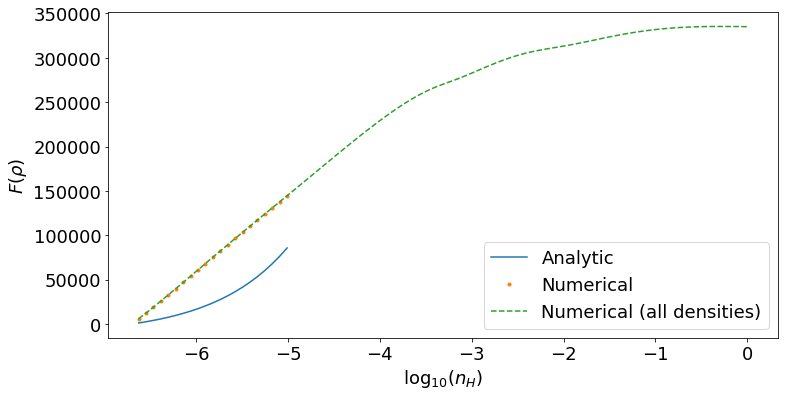

In [22]:
Fs_approx = F_analytic_approx(log_nh_analytic)
Fs_approx_numerical = [F_numerical(nh) for nh in log_nh_analytic]
Fs_numerical = [F_numerical(nh) for nh in log_nh_valid]

plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\log_{10}(n_H)$')
ax.set_ylabel(r'$F(\rho)$')
plt.plot(log_nh_analytic, Fs_approx, label='Analytic')
plt.plot(log_nh_analytic, Fs_approx_numerical, '.', label='Numerical')
plt.plot(log_nh_valid, Fs_numerical, '--', label='Numerical (all densities)')
plt.legend();

# $T_\mathrm{200}$

$$T_{200}(M_{200})=\frac{\mu m_p G}{2k_B}\left(\frac{800\pi\rho_\mathrm{crit}}{3}\right)^{1/3}{M_{200}}^{2/3}$$

4.33361441144


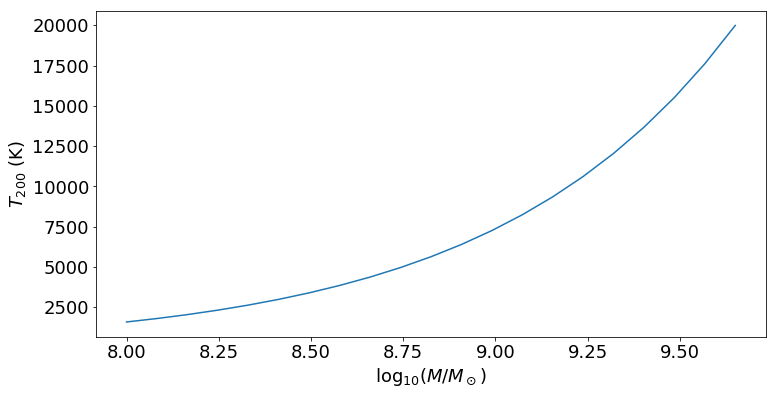

In [23]:
def Rvir(Mvir):
    return ((Mvir * solmass / (200 * rhocrit)) * (3 / (4 * np.pi)))**(1/3)

def Tvir(Mvir):   
    return (mu * mp / (2 * kB)) * (G * Mvir * solmass) / Rvir(Mvir)


masses = np.logspace(8, 9.65, 21) # in M_sun
T200s = Tvir(masses)
R200s = Rvir(masses)

print(np.log10(Tvir(5*10**9)))

plt.figure()
ax = plt.gca()
#ax.set_yscale('log')
ax.set_xlabel(r'$\log_{10}(M/M_\odot)$')
ax.set_ylabel(r'$T_{200}$ (K)')
plt.plot(np.log10(masses), T200s);
#plt.plot(masses, (1e4) * G * (masses * solmass / Rvir(masses))/(17*1e5)**2)

# $G(r)$

$$\widetilde{M}(\tilde{r})=\frac{\log(1+\tilde{r}c)-\tilde{r}c/(1+\tilde{r}c)}{\log(1+c)-c/(1+c)}$$

\begin{align}
G(r)&=-2T_{200}\int_\infty^r\frac{\widetilde{M}(\tilde{r'})}{\tilde{r'}^2}\,\mathrm{d}\tilde{r'}\\
&=2T_{200}\frac{\log(1+rc)}{\left[\log(1+c)-c/(1+c)\right]r}
\end{align}

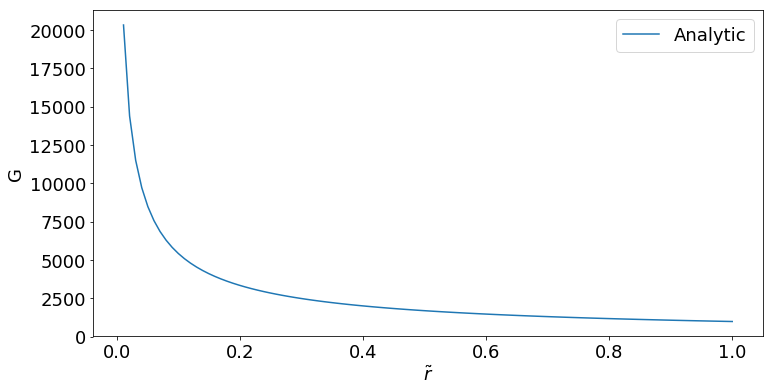

In [24]:
def G_analytic(rtw, c, Mvir):
    x = rtw * c
    return -2 * Tvir(Mvir) * -np.log(1 + x) / (rtw * (np.log(1 + c) - c / (1 + c)))

plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\tilde{r}$')
ax.set_ylabel('G')
plt.plot(np.linspace(0.01, 1, 101), G_analytic(np.linspace(0.01, 10, 101), 10, 10**8), label='Analytic')
plt.legend();


## Concentration parameters

Loading Eagle mass-concentration parameter relation data
Loading Prada mass-concentration parameter relation data


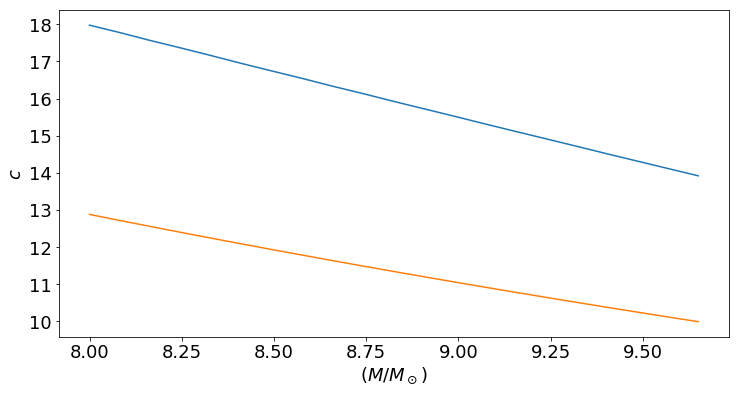

In [25]:
def make_c_interp(model_str):
    try:
        ms, cs = np.loadtxt('data/Mvir_c_{:s}.dat'.format(model_str.title()), unpack=True)
    except IOError:
        print('{:s} mass-concentration parameter relation data not found\nAborting...'.format(model_str))
        exit()
    else:
        print('Loading {:s} mass-concentration parameter relation data'.format(model_str.title()))
    return scipy.interpolate.interp1d(ms, cs)

c_interp = make_c_interp('eagle')
c_interp2 = make_c_interp('prada')

plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$(M/M_\odot)$')
ax.set_ylabel(r'$c$')
plt.plot(np.log10(masses), c_interp(masses))
plt.plot(np.log10(masses), c_interp2(masses));

# $\rho_\mathrm{gas}(r)$

$$\rho(\tilde{r})=\bar{\rho}\left[\frac{2\gamma_0}{\gamma_0 + 1}\left(\frac{T_{200}}{T_0}\right)\left(\frac{\rho_0}{\bar{\rho}}\right)^{\gamma_0}\frac{\log(1+\tilde{r}c)}{\tilde{r}\left[\log(1+c)-c/(1+c)\right]}+1\right]^{1/\gamma_0}$$

In [26]:
import multiprocessing
from sys import version_info
import time
import signal

if version_info.major < 3:
    from itertools import repeat, izip
else:
    from itertools import repeat

def rho_analytic(rtws, c, Mvir):
    rhob = 10**log_mean_nh * mp
    return rhob * (gamma0 / (gamma0 + 1) * (1 / T0) * (rho0 / rhob)**gamma0 
                   * G_analytic(rtws, c, Mvir) + 1)**(1 / gamma0)

class Py2StarHelper:
    def __init__(self, func):
        self.f = func
    def __call__(self, packed_args):
        return self.f(*packed_args)

def kernel(rtw, c, Mvir):
    rhs = G_analytic(rtw, c, Mvir)
    cond = lambda lognh: np.abs(F_numerical(lognh) - rhs)   
    #return 10**optimize.brute(cond, ((log_mean_nh, 0),))[0] * mp
    return 10**scipy.optimize.minimize_scalar(cond, bounds=(log_mean_nh, 0), method='bounded').x * mp

py2_kernel = Py2StarHelper(kernel)

N_CPUS = 24

def rho_gas(rtws, c, Mvir):
    if isinstance(rtws, np.ndarray):
        print('Starting numerical run for M={:.3g}, c={:.3g} with {} workers'.format(Mvir, c, N_CPUS))
        start_time = time.time()
        sigint_handler = signal.signal(signal.SIGINT, signal.SIG_IGN)
        worker_pool = multiprocessing.Pool(N_CPUS)
        signal.signal(signal.SIGINT, sigint_handler)
        try:
            if version_info.major < 3:
                rhos = worker_pool.map_async(py2_kernel, izip(rtws, repeat(c), repeat(Mvir)), chunksize=10)
            else:
                rhos = worker_pool.starmap_async(kernel, zip(rtws, repeat(c), repeat(Mvir)), chunksize=10)
            rhos = rhos.get(timeout=600)
        except KeyboardInterrupt:
            print('Aborting...')
            worker_pool.terminate()
            exit()
        else:
            print('Completed in {:.1f}s'.format(time.time() - start_time))
            worker_pool.close()
        worker_pool.join()
    else: # calculate for a single radius
        rhos = kernel(rtws, c, Mvir)
    return rhos

## $M_\mathrm{gas}$

In [27]:
def M_gas(rads, rhos):
    if len(rads):
        return 4 * np.pi * scipy.integrate.simps(rads**2 * rhos, rads) / solmass
    else:
        return 0

In [28]:
concentration_pms = c_interp(masses)

rtws = np.geomspace(1e-3, 30, 1000)

try:
    nhaloes = len(masses)
    rtws, rhos_gas, _ = np.hsplit(np.loadtxt('rhos_gas_eagle.dat'), [1, 1 + nhaloes])
    rtws = rtws.flatten()
    rhos_gas = rhos_gas.T
except FileNotFoundError:
    print('Failed to load data, generate?')
    genq = input()
    if genq in {'yes', 'y', 'Yes'}:
        rhos_gas = np.array([rho_gas(rtws, cp, M200) for M200, cp in zip(masses, concentration_pms)])
        np.savetxt('rhos_gas_eagle.dat', rhos_gas)
        
rhos_r200 = np.array([rho_gas(1, c, Mvir) for c, Mvir in zip(concentration_pms, masses)])

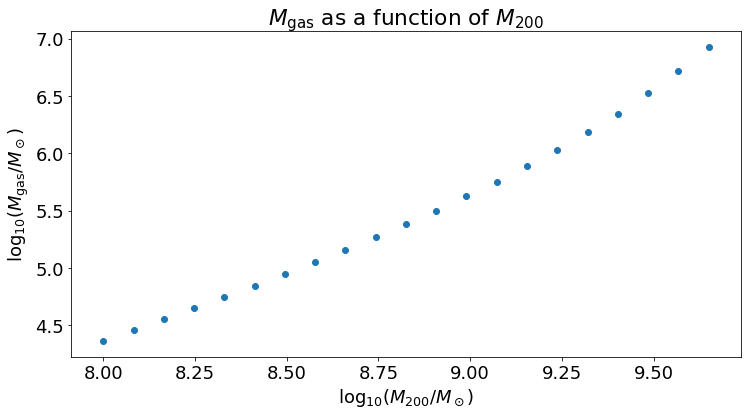

In [29]:
# M_gas = 4pi int(r^2*rho_gas)

rtws_within_r200 = rtws[rtws <= 1]

def M_gas(rads, rhos):
    if len(rads):
        return 4 * np.pi * scipy.integrate.simps(rads**2 * rhos, rads) / solmass
    else:
        return 0

gas_masses = [M_gas(rtws_within_r200 * rv, rg[rtws < 1]) for rg, rv in zip(rhos_gas, R200s)]

plt.figure()
ax = plt.gca()
ax.set_title(r'$M_\mathrm{gas}$ as a function of $M_{200}$')
ax.set_xlabel(r'$\log_{10}(M_{200}/M_\odot)$')
ax.set_ylabel(r'$\log_{10}(M_\mathrm{gas}/M_\odot)$')
plt.scatter(np.log10(masses), np.log10(gas_masses));

## Gas fractions

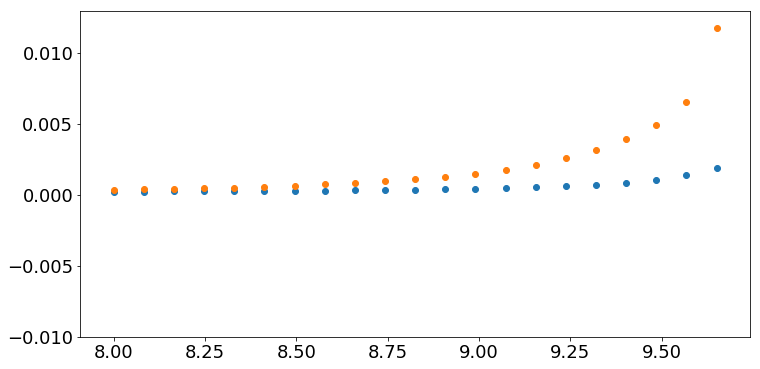

In [30]:
gas_fracs = gas_masses / masses

# spherical_cloudy
def sph_cloudy_baryfracs():
    halomass, barymass = np.loadtxt("data/baryfrac.dat", unpack=True)
    baryfracvals = 10.0**barymass / 10.0**halomass
    return scipy.interpolate.interp1d(halomass, baryfracvals)

gas_fracs_sph_cloudy = sph_cloudy_baryfracs()(np.log10(masses))

plt.figure()
plt.scatter(np.log10(masses), gas_fracs)
plt.scatter(np.log10(masses), gas_fracs_sph_cloudy);

In [31]:
# radii where enclosed gas mass = f_bar * M200
fbar = 0.167 # universal baryon fraction
mass_targets = fbar * masses

Rbars = np.empty_like(masses)
rhos_Rbar = np.empty_like(masses)

for idx, mt in enumerate(mass_targets):
    loc = np.argmin([np.abs(mt - M_gas(rtws[:trial_loc] * R200s[idx], rhos_gas[idx][:trial_loc]))
                     for trial_loc in range(len(rtws))])
    Rbars[idx] = rtws[loc] * R200s[idx]
    rhos_Rbar[idx] = rhos_gas[idx][loc]
    

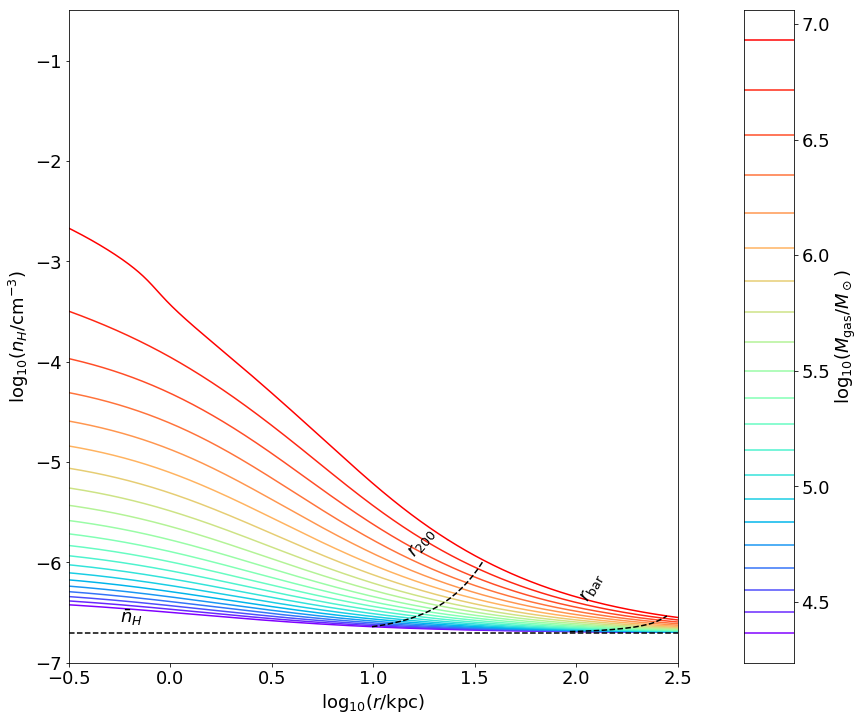

In [32]:
colourvals = np.linspace(0., 1., len(rhos_gas))
colours = [mpl.cm.rainbow(x) for x in colourvals]
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.rainbow)
sm.set_array(np.log10(gas_masses))

fig, (axm, axcb) = plt.subplots(1, 2, figsize=(13,12), gridspec_kw = {'width_ratios':[12, 1]})
axm.set_xlim(-0.5, 2.5)
axm.set_ylim(-7, -0.5)
axm.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
axm.set_ylabel(r'$\log_{10}(n_H/\mathrm{cm^{-3}})$')
for idx, rg in enumerate(rhos_gas):
    kpc_rads = rtws * R200s[idx] / cm_to_kpc
    axm.plot(np.log10(kpc_rads), np.log10(rg / mp), color=colours[idx])    
# plot virial radii
axm.plot(np.log10(R200s / cm_to_kpc), np.log10(rhos_r200 / mp), '--', c='k')
axm.text(1.15, -5.75, r'$r_{200}$', rotation=50)
# plot fbar * M200 radii
axm.plot(np.log10(Rbars / cm_to_kpc), np.log10(rhos_Rbar / mp), '--', c='k')
axm.text(2.0, -6.2, r'$r_\mathrm{bar}$', rotation=60)
# plot mean nH
axm.axhline(log_mean_nh, c='k', ls='--')
axm.text(-.25, -6.6, r'$\bar{n}_H$')
# plot colourbar
axcb.yaxis.tick_right()
axcb.yaxis.set_label_position('right')
axcb.set_ylabel(r'$\log_{10}(M_\mathrm{gas}/M_\odot)$')
axcb.xaxis.set_major_locator(mpl.ticker.NullLocator())
axcb.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
for idx, mg in enumerate(gas_masses):
    axcb.axhline(np.log10(mg), c=colours[idx])

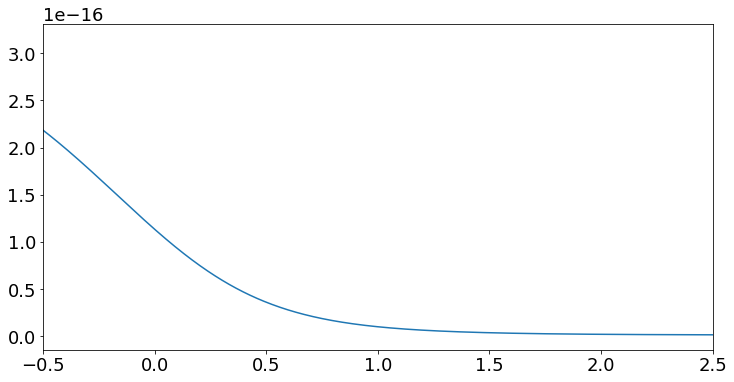

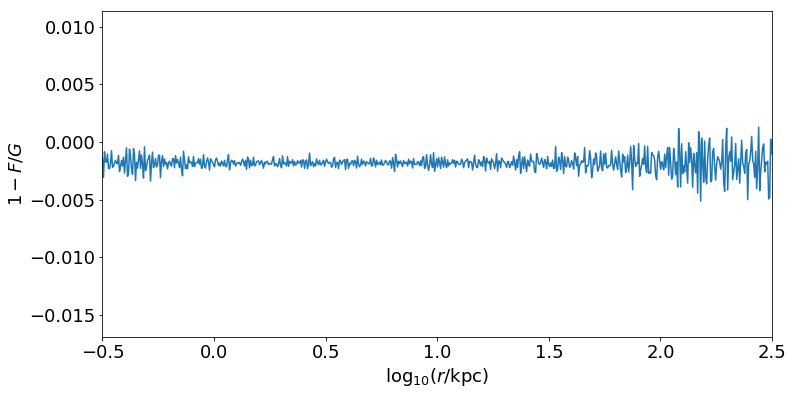

In [33]:
# Consistency check - does the solution satisfy hydrostatic equilibrium?

def P(rho):
    return rho * kB * T(np.log10(rho/mp)) / (mu * mp)

# Acceleration profile (M(<r)/r^2) from ABL et al in normalised coordinates
def accel_literature_norm(c, rtw):
    x = rtw * c
    return rtw**(-2) * (np.log(1 + x) - x/(1 + x)) / (np.log(1 + c) - c / (1 + c))

idx = 16

rho_idx = rhos_gas[idx]
rad_idx = rtws * R200s[idx] / cm_to_kpc
P_idx = P(rho_idx)
T_idx = T(rho_idx)

P_interp = scipy.interpolate.InterpolatedUnivariateSpline(rtws, P_idx)
dP_dr = P_interp.derivative()

plt.figure()
#plt.plot(rtws, P_idx)
ax = plt.gca()
ax.set_xlim(-0.5, 2.5)
plt.plot(np.log10(rad_idx), P_interp(rtws))

#plt.figure()
#plt.plot(rtws, -dP_dr(rtws))

lhs = (1 / rho_idx) * dP_dr(rtws)

rhs = -(G * masses[idx] * solmass / R200s[idx]) * accel_literature_norm(concentration_pms[idx], rtws)

plt.figure()
ax = plt.gca()
ax.set_xlabel(r'$\log_{10}(r/\mathrm{kpc})$')
ax.set_ylabel('$1-F/G$')
ax.set_xlim(-0.5, 2.5)
#ax.set_ylim(-0.02, 0.02)
plt.plot(np.log10(rad_idx), 1-lhs/rhs);